# graph_drs_data_access_rates

Graph the number of Terra workflow DRS localization operations started per second,
based on Terra workflow log timestamps for log entries containing:
`Localizing input drs://`

The input data for this Notebook is prepared by the `extract_drs_localization_timestamps.sh` script, here:
https://github.com/mbaumann-broad/data-wrangling/blob/workflow_data_access_rate/scripts/workflow_drs_data_access_rate/extract_drs_localization_timestamps.sh

TODO Update to the new repo location when available there.

In [209]:
DATA_ACCESS_RATE_INPUT_FILE = f"{WF_TEST_RESULTS_DIR}/drs_localization_timeseries.tsv"
FALLBACK_RATE_INPUT_FILE= f"{WF_TEST_RESULTS_DIR}/drs_localization_fallback_timeseries.tsv"

In [210]:
from typing import Any

import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd

In [211]:
class DataAccessRateDisplayMethods:
    def __init__(self, input_filename: str,
                 graph_title: str,
                 timestamp_columnname: str,
                 data_access_count_columnname: str,
                 is_subplot: bool = False,
                 figure_width: float = 10,
                 figure_height: float = 6.18):
        self.input_filename = input_filename
        self.graph_title = graph_title
        self.timestamp_columnname = timestamp_columnname
        self.data_access_count_columnname = data_access_count_columnname
        self.is_subplot = is_subplot
        self.figure_width = figure_width
        self.figure_height = figure_height
        plt.style.use("fast")

    def load_file_to_df(self, sep: str = ',') -> pd.DataFrame:
        df = pd.read_csv(self.input_filename, sep=sep)
        return df

    def clean_up_data(self, df: pd.DataFrame) -> pd.DataFrame:
        # Extract the columns of interest from any others that may be present
        keep_columns = [self.timestamp_columnname,
                        self.data_access_count_columnname]
        df = df[keep_columns]

        # Remove all rows that are completely empty
        df = df.dropna(how='all') # Removes all rows that are completely empty

        # Sort by the timestamp column
        df = df.sort_values(by=[self.timestamp_columnname])

        return df

    def update_timestamp_column(self, df: pd.DataFrame) -> pd.DataFrame:
        df[self.timestamp_columnname] = pd.to_datetime(df[self.timestamp_columnname])

        # Set the timestamp column as the first column
        cols = list(df)
        cols.insert(0, cols.pop(cols.index(self.timestamp_columnname)))
        df = df.loc[:, cols]

        df.set_index(self.timestamp_columnname, drop=False)
        return df

    def resample_data_to_total_rate_per_second(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.resample(pd.Timedelta(1, 'second'),
                         on=self.timestamp_columnname)['Count'].sum().reset_index()
        df = df.set_index(self.timestamp_columnname, drop=False)
        return df

    def format_x_axis_time(self) -> None:
        ax = plt.gca() # Get current axes
        ax.xaxis.set_major_locator(mdates.HourLocator())
        ax.xaxis.set_minor_locator(mdates.MinuteLocator(byminute=range(0, 59, 5)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d %H:%M'))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%H:%M"))
        for label in ax.get_xticklabels(which='major'):
            label.set(rotation=90, horizontalalignment='right')
        for label in ax.get_xticklabels(which='minor'):
            label.set(rotation=90, horizontalalignment='right')

    def add_legend(self) -> None:
        ax = plt.gca() # Get current axes
        ax.legend(loc='upper left', frameon=True, edgecolor="b")

    def draw_line_graph(self, df: pd.DataFrame, line_format_kwargs=dict()) -> None:
        plt.xlabel("Time (UTC)")
        self.format_x_axis_time()
        plt.ylabel("DRS Data Accesses Per Second")
        plt.title(self.graph_title)
        plt.plot(df[self.timestamp_columnname],
                 df[self.data_access_count_columnname],
                 # linestyle="-", color="b", label="DRS data access rate per second"
                 **line_format_kwargs)

    def add_markers(self, df: pd.DataFrame,
                    value_columnname: str, match_value: Any,
                    marker: str, marker_color: str,
                    label: str) -> None:
        df_matches = df[df[value_columnname] == match_value]
        if df_matches.shape[0] == 0: # No matching rows
            return
        x_axis_match_timestamps = df_matches[self.timestamp_columnname]
        y_axis_match_response_duration = df_matches[self.data_access_count_columnname]

        plt.scatter(x_axis_match_timestamps, y_axis_match_response_duration,
                    marker=marker, c=marker_color, label=label)

    # def draw_success_markers(self, df: pd.DataFrame) -> None:
    #     self.add_markers(df, self.response_reason_columnname, "OK",
    #                      marker='o', marker_color='g', label="Success (2xx)")
    #
    # def draw_error_markers(self, df):
    #     # For colors available, see: https://matplotlib.org/stable/gallery/color/named_colors.html
    #     for status_code, color in (401, "k"), (500, "r"), (502, mcolors.TABLEAU_COLORS['tab:orange']):
    #         self.add_markers(df, self.response_code_columnname, status_code,
    #                          marker='v', marker_color=color, label=f"Error ({status_code})")

    def draw_line_graph_with_error_markers(self, df: pd.DataFrame, line_format_kwargs: dict =dict()) -> None:
        self.draw_line_graph(df, line_format_kwargs)
        # self.draw_success_markers(df)
        # self.draw_error_markers(df)
        self.add_legend()

    def display_statistics(self, df: pd.DataFrame, statistics_title) -> None:
        print(statistics_title)
        print(f"Maximum value:\t{round(df[self.data_access_count_columnname].max(), 1)}")
        print(f"Mean value:\t{round(df[self.data_access_count_columnname].mean(), 1)}")
        print(f"95th quantile:\t{round(df[self.data_access_count_columnname].quantile(0.95), 1)}")
        print()

    def display_data_access_rate(self, line_format_kwargs: dict = dict()) -> None:
        df = self.load_file_to_df(sep='\t')
        df = self.clean_up_data(df)
        df = self.update_timestamp_column(df)
        df = self.resample_data_to_total_rate_per_second(df)
        statistics_title = line_format_kwargs['label'] if line_format_kwargs.get('label') else self.graph_title
        self.display_statistics(df, statistics_title)
        if not self.is_subplot:
            plt.figure(1, figsize=(self.figure_width, self.figure_height))
        self.draw_line_graph_with_error_markers(df, line_format_kwargs)

In [212]:
def display_drs_data_access_rates(input_filename: str, line_format_kwargs=dict(), is_subplot: bool = False) -> None:
    graph_title = "DRS Data Access Rates"
    displayer = DataAccessRateDisplayMethods(input_filename, graph_title,
                                             'Timestamp', 'Count',
                                             is_subplot=is_subplot)
    displayer.display_data_access_rate(line_format_kwargs)
    if not is_subplot:
        plt.show()

In [213]:
def display_drs_data_access_and_fallback_rates(data_access_rate_filename: str, fallback_rate_filename: str) -> None:
    plt.figure(figsize=(10, 6.8))
    is_subplot = True

    plt.subplot(1, 1, 1)
    line_format_kwargs = dict(linestyle="-", color="b", label="DRS data access rate per second")
    display_drs_data_access_rates(data_access_rate_filename, line_format_kwargs, is_subplot)

    plt.subplot(1, 1, 1)
    line_format_kwargs = dict(linestyle="-", color="r", label="Fallback rate per second")
    display_drs_data_access_rates(fallback_rate_filename, line_format_kwargs, is_subplot)

    plt.show()

DRS data access rate per second
Maximum value:	20 seconds
Mean value:		3.8 seconds
95th quantile:	10.0 seconds

Fallback rate per second
Maximum value:	19 seconds
Mean value:		2.4 seconds
95th quantile:	8.0 seconds



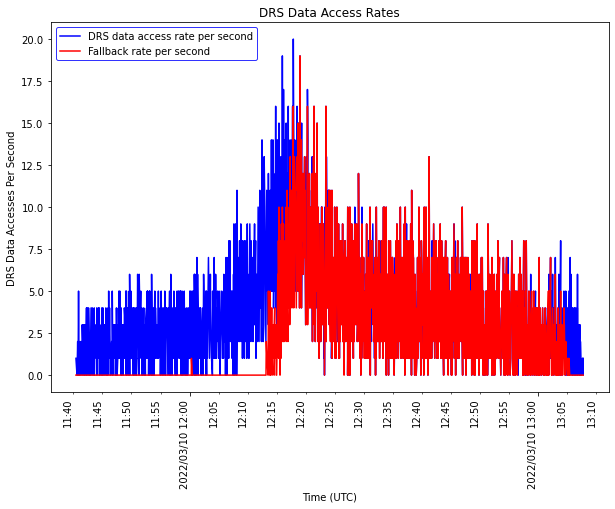

In [214]:
display_drs_data_access_and_fallback_rates(DATA_ACCESS_RATE_INPUT_FILE, FALLBACK_RATE_INPUT_FILE)

DRS data access rate per second
Maximum value:	20 seconds
Mean value:		3.8 seconds
95th quantile:	10.0 seconds



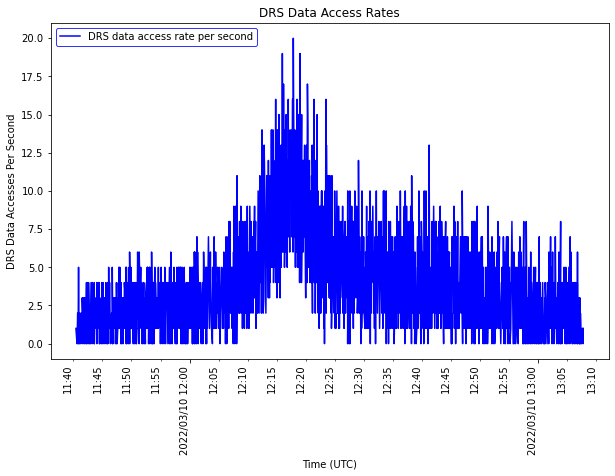

In [215]:
import traceback
try:
    line_format_kwargs = dict(linestyle="-", color="b", label="DRS data access rate per second")
    display_drs_data_access_rates(DATA_ACCESS_RATE_INPUT_FILE, line_format_kwargs)
except Exception as ex:
    print(traceback.print_exc())

Fallback rate per second
Maximum value:	19 seconds
Mean value:		2.4 seconds
95th quantile:	8.0 seconds



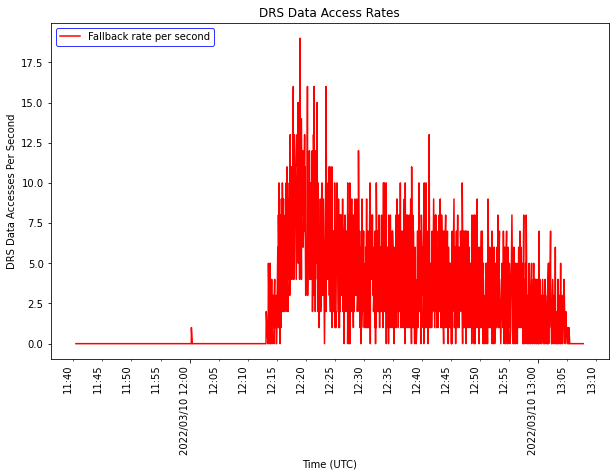

In [216]:
import traceback
try:
    line_format_kwargs = dict(linestyle="-", color="r", label="Fallback rate per second")
    display_drs_data_access_rates(FALLBACK_RATE_INPUT_FILE, line_format_kwargs)
except Exception as ex:
    print(traceback.print_exc())